In [1]:
# Check device
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    print("device_count: {}".format(device_count))
    for device_num in range(device_count):
        print("device {} capability {}".format(
            device_num,
              torch.cuda.get_device_capability(device_num)))
        print("device {} name {}".format(device_num, torch.cuda.get_device_name(device_num)))
else:
    print("no cuda device")

device_count: 1
device 0 capability (7, 5)
device 0 name Tesla T4


In [2]:
# Mounting google drive
from google.colab import drive, files
drive.mount('/content/gdrive/')

%cd gdrive/MyDrive/Colab\ Notebooks/CR-COPEC

Mounted at /content/gdrive/
/content/gdrive/MyDrive/Colab Notebooks/CR-COPEC


In [3]:
# Install requirements
from IPython.display import clear_output

!pip install tensorflow_text==2.8.1
clear_output()

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

seed_value= 0
os.environ['PYTHONHASHSEED'] = str(seed_value)
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

tf.__version__

'2.8.4'

In [5]:
# predefine hyperparameters and model-type
model_name='bert_base'
current_lr= 2e-6
epoch=1
batch=32

 ## Load Data

In [7]:
# Load the dataset into a pandas dataframe.
train_df = pd.read_csv("data/cr-copec_total_train.csv")
val_df = pd.read_csv("data/cr-copec_total_va.csv")
test_df = pd.read_csv("data/cr-copec_total_test.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_df.shape[0]))
print('Number of valid sentences: {:,}\n'.format(val_df.shape[0]))
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Display 5 rows from the data.
train_df.head(5)

<ipython-input-7-6a27ca949d1c>:2: DtypeWarning: Columns (1,3,7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("data/cr-copec_total_train_.csv")


Number of training sentences: 228,879

Number of valid sentences: 25,431

Number of test sentences: 29,176



,sentence,section,document,date,loc,true_label,file_name,Unnamed: 7
0,ITEM 7.,1,232556100,19970502,0,no,sec01_2330_232556100-10-K-19970502,NaN
1,"On April 7, 1995, Cygne sold the United Kingdo...",1,232556100,19970502,2,no,sec01_2330_232556100-10-K-19970502,NaN
2,"On February 9, 1996, the Company sold substant...",1,232556100,19970502,3,no,sec01_2330_232556100-10-K-19970502,NaN
3,"On September 20, 1996, the Company sold its 60...",1,232556100,19970502,4,no,sec01_2330_232556100-10-K-19970502,NaN
4,Since the consummation of the Ann Taylor Dispo...,1,232556100,19970502,6,no,sec01_2330_232556100-10-K-19970502,NaN


In [8]:
# Get the lists of sentences and their labels.
train_texts, train_labels = train_df.sentence.values.tolist(), [1 if i=='yes' else 0 for i in train_df.true_label.values]
val_texts, val_labels = val_df.sentence.values.tolist(), [1 if i=='yes' else 0 for i in val_df.true_label.values]
test_texts, test_labels = test_df.sentence.values.tolist(), [1 if i=='yes' else 0 for i in test_df.true_label.values]

train_ds = tf.data.Dataset.from_tensor_slices((train_texts,train_labels)).shuffle(len(train_texts), seed=seed_value).batch(batch)
val_ds = tf.data.Dataset.from_tensor_slices((val_texts,val_labels)).shuffle(len(val_texts), seed=seed_value).batch(32)

## Load Model

In [9]:
if model_name == 'bert_base':
  model_path ='https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
  model_preprocess ='https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

elif model_name == 'electra_base':
  model_path = 'https://tfhub.dev/google/electra_base/2'
  model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

tfhub_handle_encoder = model_path
tfhub_handle_preprocess = model_preprocess

def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, dtype=tf.float64, trainable=True, name=model_name+'_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.3, seed=seed_value)(net)
    net = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), activation='sigmoid', name='classifier')(net)
    model=tf.keras.Model(text_input, net)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=current_lr),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics=tf.metrics.BinaryAccuracy())
    model.summary()
    return model

# Train Model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

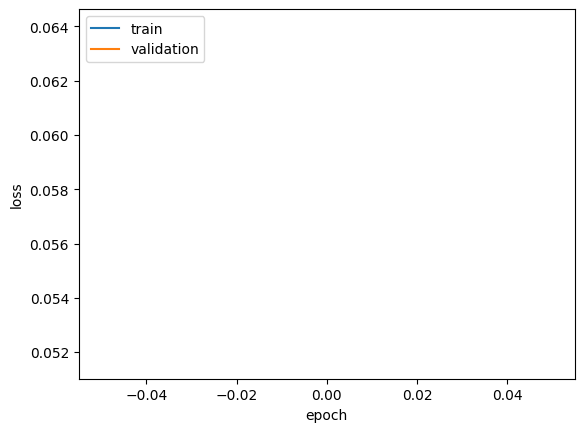

In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint

def namefile(model_name):
    filepath= "#models/tensorflow_"+model_name+".hdf5"
    return filepath

for fold in range(1):
    tf.keras.utils.set_random_seed(seed_value)
    os.environ["TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS"]="True"


    model = build_model()
    filepath= namefile(model_name)

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]

    print(f'Training model with {tfhub_handle_encoder}')
    history = model.fit(x=train_ds,
                                    validation_data=val_ds,
                                    epochs=epoch,
                                    callbacks=callbacks_list,
                                    shuffle=False)

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# Test Model

In [11]:
def load_model(file):
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, dtype=tf.float64, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.3, seed=seed_value)(net)
    net = tf.keras.layers.Dense(1, kernel_initializer=tf.keras.initializers.GlorotUniform(seed=seed_value), activation='sigmoid', name='classifier')(net)
    model=tf.keras.Model(text_input, net)
    model.load_weights(file)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=current_lr),
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                             metrics=tf.metrics.BinaryAccuracy())
    return model

In [12]:
filepath= namefile(model_name)
model = load_model(filepath)

text_sample1=['The decline in Consumer Product Segment gross profit margin is mainly attributable to increased levels of royalty cost resulting from changes in the sales mix towards the higher royalties associated with licensed characters products, and a deterioration in the gross profit margins at Penn which decreased to 12.0% from 22.1%.']
text_sample2=['The increase in unit shipments and average selling price reflects the OEMs continued move to finished luggage compartments.']

print(model.predict(text_sample1))
print(model.predict(text_sample2))

[[0.9809161]]
[[0.11681046]]
